# Проект: Анализ сервиса аренды самокатов GoFast

Есть данные популярного сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также об их поездках. 

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

- без подписки:
абонентская плата отсутствует;
стоимость одной минуты поездки — 
8 рублей;
стоимость старта (начала поездки) — 
50 рублей;

- с подпиской Ultra:
абонентская плата — 
199 рублей в месяц;
стоимость одной минуты поездки — 
6 рублей;
стоимость старта — бесплатно.

Данные представлены в трех таблицах users_go.csv, rides_go.csv,  subscriptions_go.csv.

**Цель исследования:**

Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

**Ход исследования:**

- Обзор и предобработка данных.
- Исследовательский анализ данных.
- Объединение данных.
- Подсчет выручки.
- Проверка гипотез.

In [1]:
# импорт библиотек
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

Пути к файлам: 
- Пользователи: /datasets/users_go.csv
- Поездки: /datasets/rides_go.csv
- Подписки: /datasets/subscriptions_go.csv

In [3]:
# просмотр информации о таблицах
for i in [users, riders, subscriptions]:
    display(i.head())
    display(i.info())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

Структура users_go.csv:
- user_id - уникальный идентификатор пользователя
- name - имя пользователя
- age - возраст
- city - город
- subscription_type - тип подписки (free, ultra)

Структура rides_go.csv:
- user_id - уникальный идентификатор пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date - дата совершения поездки

Структура subscriptions_go.csv:

- subscription_type - тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа   

Пропусков в таблицах нет. В таблице riders необходимо привести столбец с датой к корректному типу данных.

Посмотрим распределение значений в столбцах с количественными показателями.

In [4]:
users['age'].describe()

count    1565.000000
mean       24.922045
std         4.553496
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Минимальный возраст 12, максимальный 43, здесь все в порядке.

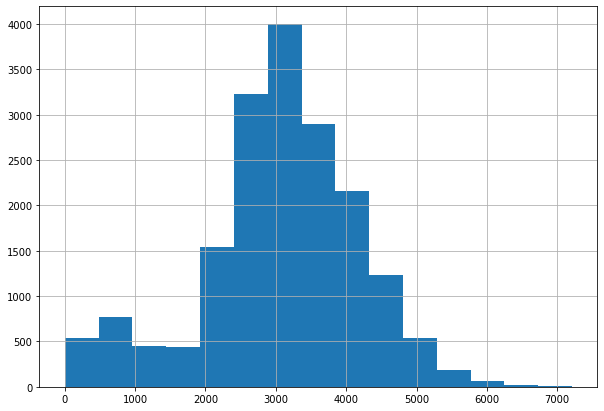

In [5]:
riders['distance'].hist(bins=15, figsize=(10, 7))
plt.show()

В столбце distance датафрейма riders есть значения, равные нулю. Возможно пользователи принимали решение не ехать на самокате.

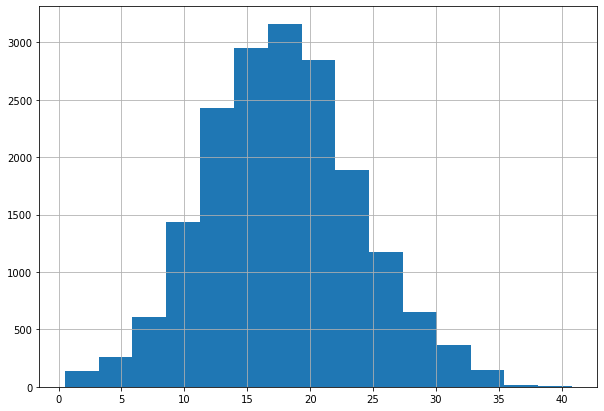

In [6]:
riders['duration'].hist(bins=15, figsize=(10, 7))
plt.show()

В столбце duration датафрейма riders есть значения, близкие к нулю. Такое возможно, но необходимо проверить значения преодоленного расстояния для таких сессий.

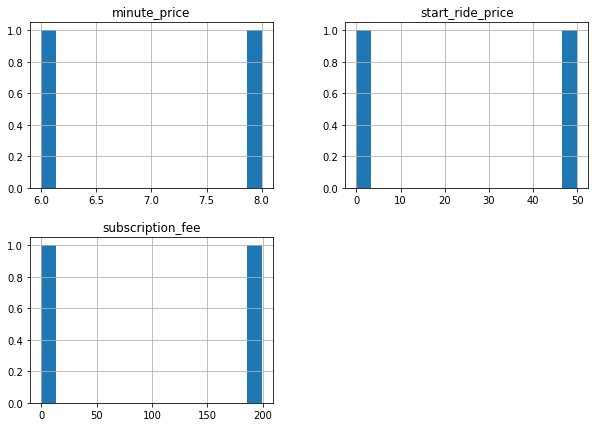

In [7]:
subscriptions.hist(bins=15, figsize=(10, 7))
plt.show()

В датафрейме subscriptions значения корректные.

#### Шаг 2. Предобработка данных

Данные о времени приведем к соответствующему типу.

In [8]:
# меняем тип данных
riders['date'] = pd.to_datetime(riders['date'])

In [9]:
# проверяем типы данных в датафрейме
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Проверим датафреймы на наличие явных дубликатов.

In [10]:
# проверяем наличие дубликатов
for i in [users, riders, subscriptions]:
    display(i.duplicated().sum())

31

0

0

Есть дубликаты в датафрейме users. Удалим их.

In [11]:
# удаляем явные дубликаты
users.drop_duplicates(inplace=True)

Изучим категориальные значения в датафреймах.

In [12]:
users['city'].sort_values().unique()

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

In [13]:
users['subscription_type'].sort_values().unique()

array(['free', 'ultra'], dtype=object)

Неявных дубликатов нет.

Проверим количественные значения. В начале исследования было выявлено, что в столбцах distance и duration возможно присутствуют выбросы. Построим диаграмму размаха для каждого из столбцов, чтобы исключить такие значения.

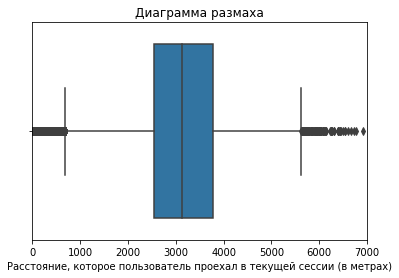

In [14]:
# диаграмма размаха для столбца distance:
sns.boxplot(riders['distance'])
plt.title('Диаграмма размаха')
plt.xlabel('Расстояние, которое пользователь проехал в текущей сессии (в метрах)')
plt.xlim(0, 7000)
plt.show()

In [15]:
riders['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Нормальные значения для столбца distance находятся в диапозоне от 600 до 5600 метров. Исключать другие значения не станем, так как пользователь мог проехать и 7000 метров, и не ехать вообще, если например передумал.

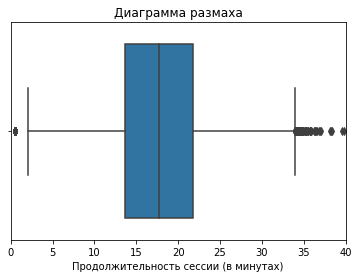

In [16]:
# диаграмма размаха для столбца duration:
sns.boxplot(riders['duration'])
plt.title('Диаграмма размаха')
plt.xlabel('Продолжительность сессии (в минутах)')
plt.xlim(0, 40)
plt.show()

In [17]:
riders['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Нормальные значения лежат в промежутке от 2 до 35 минут. При этом минимальное значение составляет 0.5. Посмотрим на строки, где продолжительность поездки составила 0.5 минут.

In [18]:
duration_05 = riders.loc[(riders['duration'] == 0.5)]
duration_05

,user_id,distance,duration,date
6531,701,4196.445201,0.5,2021-08-31
6570,704,4830.824371,0.5,2021-10-14
6680,712,4684.004397,0.5,2021-03-04
6695,713,5215.642710,0.5,2021-02-25
6768,718,5197.436649,0.5,2021-02-11
...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19
17242,1477,6724.932981,0.5,2021-01-12
17314,1483,4445.481070,0.5,2021-03-06
17505,1496,5722.551787,0.5,2021-02-14


Таких строк 95. Следуюет обратить внимание на преодоленное расстояние в эти сессии. За полминуты невозможно проехать такие расстояния. Это технический сбой.

Посчитаем долю сессий с продолжительностью 0.5 минуты относительно всего датафрейма. Если доля будет меньше 5%, то удалим строки.

In [19]:
(100 * len(riders.loc[(riders['duration'] == 0.5)])) / len(riders)

0.5257914545052026

Доля составила менее одного процента, удалим строки.

In [20]:
riders = riders.loc[(riders['duration'] != 0.5)]
riders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17973 non-null  int64         
 1   distance  17973 non-null  float64       
 2   duration  17973 non-null  float64       
 3   date      17973 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 702.1 KB


Добавим столбец с номером месяца. Для начала посмотрим за какие года представлены данные.

In [21]:
riders['date'].dt.year.unique()

array([2021])

Данные представлены за 2021 год. Можно добавить столбец с указанием месяца без года.

In [22]:
riders['month'] = riders['date'].dt.month
riders.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


#### Шаг 3. Исследовательский анализ данных

**Частота встречаемости городов**

Создадим сводную таблицу по количеству пользователей по городам.

In [23]:
# создаем сводную таблицу по городам
count_by_city = users.groupby('city')['user_id'].agg('count').sort_values(ascending = False).reset_index()
count_by_city.columns = ['city', 'count']
count_by_city['ratio'] = round(count_by_city['count'] / count_by_city['count'].sum(), 2) * 100
count_by_city

,city,count,ratio
0,Пятигорск,219,14.0
1,Екатеринбург,204,13.0
2,Ростов-на-Дону,198,13.0
3,Краснодар,193,13.0
4,Сочи,189,12.0
5,Омск,183,12.0
6,Тюмень,180,12.0
7,Москва,168,11.0


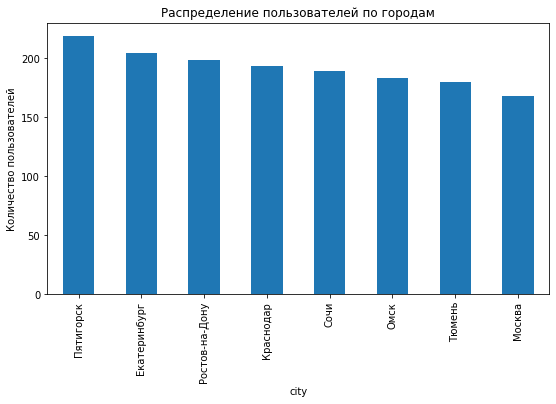

In [24]:
# создаем график, отображающий распределение пользователей по городам
(count_by_city.sort_values(by='count', ascending=False)
    .plot(kind='bar', figsize=(9, 5), x='city', y='count', title='Распределение пользователей по городам', 
          legend = False))
plt.ylabel('Количество пользователей')
plt.show()

Больше всего пользователей в Пятигорске - 219 пользователей, что составляет 14% от общего числа пользователей. Меньше всего в Москве - 168 пользователей. 

**Соотношение пользователей с подпиской и без подписки**

Создадим сводную таблицу по соотношению пользователей с подпиской и без подписки.

In [25]:
# создаем сводную таблицу по пользователям с подпиской и без
count_subscription_type = users['subscription_type'].value_counts().sort_values(ascending = False).reset_index()
count_subscription_type.columns = ['subscription_type', 'count']
count_subscription_type['ratio'] = round(count_subscription_type['count'] / count_subscription_type['count'].sum(), 2) * 100
count_subscription_type

,subscription_type,count,ratio
0,free,835,54.0
1,ultra,699,46.0


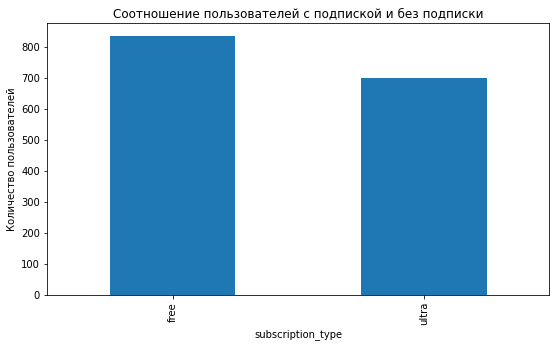

In [26]:
# создаем график, отображающий распределение пользователей с подпиской и без
(count_subscription_type.sort_values(by='count', ascending=False)
    .plot(kind='bar', figsize=(9, 5), x='subscription_type', y='count', 
          title='Соотношение пользователей с подпиской и без подписки', 
          legend = False))
plt.ylabel('Количество пользователей')
plt.show()

Больше пользователей без подписки - 54% против 46%.

**Возраст пользователей**

Построим график, отображающий распределение пользователей по возрасту.

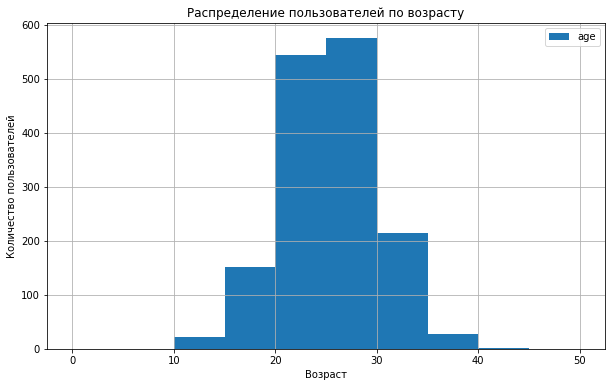

In [27]:
users.plot(kind='hist', y='age', title='Распределение пользователей по возрасту', 
              bins=10, range = (0, 50), figsize=(10,6), grid=True)

plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

Чаще всего самокатами пользуются в возрасте от 20 до 30 лет.

**Расстояние, которое пользователь преодолел за одну поездку**

In [28]:
riders['distance'].describe()

count    17973.000000
mean      3059.863833
std       1108.814612
min          0.855683
25%       2538.839628
50%       3129.029255
75%       3762.636244
max       7066.003772
Name: distance, dtype: float64

Минимальное расстояние за одну сессию составляет 0.86 метров. Максимальное - 7066 метров.

Построим график, отображающий распределение преодоленных за сессию расстояний.

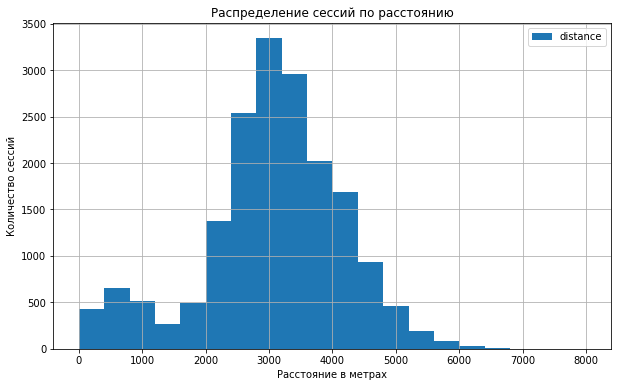

In [29]:
riders.plot(kind='hist', y='distance', title='Распределение сессий по расстоянию', 
              bins=20, range = (0, 8000), figsize=(10,6), grid=True)

plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество сессий')
plt.show()

Чаще всего расстояния составляют от 2500 до 3500 метров.

**Продолжительность поездок**

In [30]:
riders['duration'].describe()

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

Построим график по продолжительности сессий.

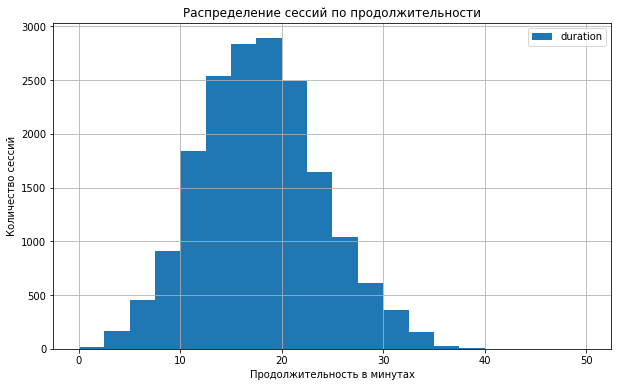

In [31]:
riders.plot(kind='hist', y='duration', title='Распределение сессий по продолжительности', 
              bins=20, range = (0, 50), figsize=(10,6), grid=True)

plt.xlabel('Продолжительность в минутах')
plt.ylabel('Количество сессий')
plt.show()

Чаще всего поездка длится от 10 до 25 минут. 

**Вывод:**

Количество пользователей по городам распределены примерно одинаково в пределах 11-14%. При этом наибольшее количество приходится на Пятигорск - 219 пользователей, а наименьшее в Москве - 168. Возможно это связано с тем, что в Москве выше конкуренция. 

Чаще пользователи пользуются приложением без подписки: 54 % против 46%.

Чаще всего самокатами пользуются люди в возрасте от 20 до 30 лет.

Одна поездка в среднем составляет примерно 3000 метров и длится от 10 до 25 минут.

#### Шаг 4. Объединение данных

Объединим таблицы.

In [32]:
merge_data = users.merge(riders)
merge_data = merge_data.merge(subscriptions)

In [33]:
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   name               17973 non-null  object        
 2   age                17973 non-null  int64         
 3   city               17973 non-null  object        
 4   subscription_type  17973 non-null  object        
 5   distance           17973 non-null  float64       
 6   duration           17973 non-null  float64       
 7   date               17973 non-null  datetime64[ns]
 8   month              17973 non-null  int64         
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


В результате объединения получился датафрейм с 17973 строками, что соответствует количеству строк в таблице users.

Создадим датафреймы с данными о пользователях с подпиской и без.

In [34]:
# создаем датафрейм с пользователями с подпиской
ultra_subscriptions = merge_data.query("subscription_type == 'ultra'")
ultra_subscriptions

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


In [35]:
# создаем датафрейм с пользователями без подписки
free_subscriptions = merge_data.query("subscription_type == 'free'")
free_subscriptions

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
17969,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
17970,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
17971,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


Визуализируем данные о расстоянии поездок в этих двух датафреймах.

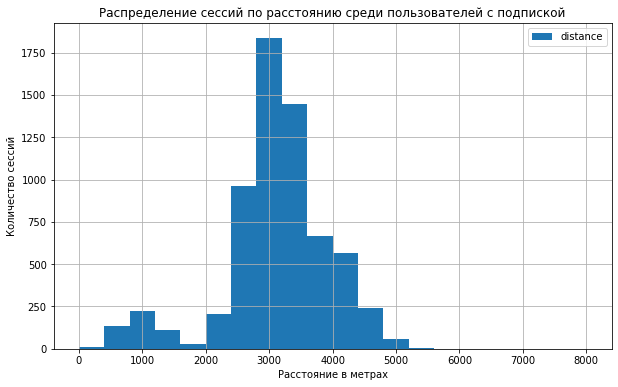

In [36]:
# график для пользователей с подпиской
ultra_subscriptions.plot(kind='hist', y='distance', 
                         title='Распределение сессий по расстоянию среди пользователей с подпиской', 
                         bins=20, range = (0, 8000), figsize=(10,6), grid=True)

plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество сессий')
plt.show()

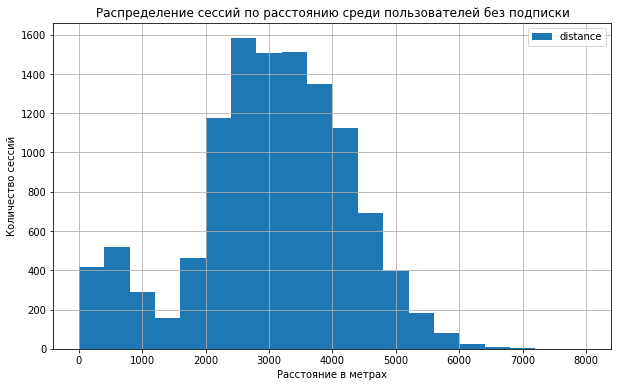

In [37]:
# график для пользователей без подписки
free_subscriptions.plot(kind='hist', y='distance', 
                        title='Распределение сессий по расстоянию среди пользователей без подписки', 
                        bins=20, range = (0, 8000), figsize=(10,6), grid=True)

plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество сессий')
plt.show()

Пользователи с подпиской совершают более короткие поездки, пик приходится на 3000 метров. Для пользователей без подписки преодоленные расстояния имеют большую вариантивность. Можно предположить, что это связано с тем, что подписку оформляют в случаях, когда поездки регулярны, например ежедневные поездки до работы. А поездки без подписки более ситуативны, например прогулки.

Визуализируем данные о продолжительности поездок в этих двух датафреймах.

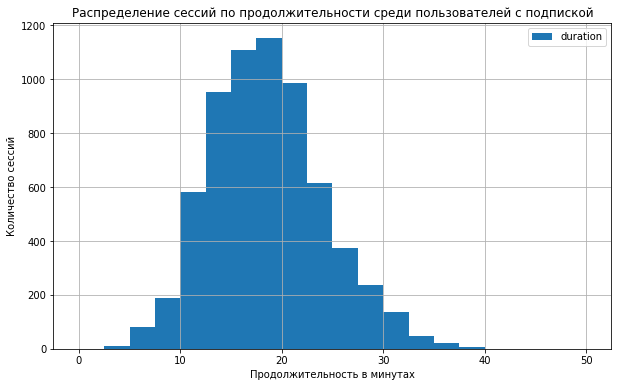

In [38]:
# график для пользователей с подпиской
ultra_subscriptions.plot(kind='hist', y='duration', 
                         title='Распределение сессий по продолжительности среди пользователей с подпиской', 
                         bins=20, range = (0, 50), figsize=(10,6), grid=True)

plt.xlabel('Продолжительность в минутах')
plt.ylabel('Количество сессий')
plt.show()

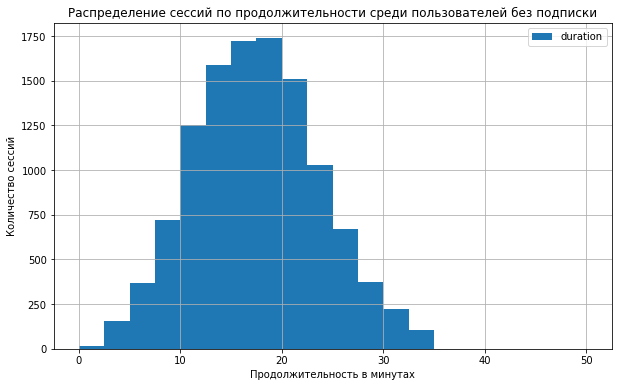

In [39]:
# график для пользователей без подписки
free_subscriptions.plot(kind='hist', y='duration', 
                        title='Распределение сессий по продолжительности среди пользователей без подписки', 
                        bins=20, range = (0, 50), figsize=(10,6), grid=True)

plt.xlabel('Продолжительность в минутах')
plt.ylabel('Количество сессий')
plt.show()

В обоих случаях чаще всего продолжительность поездок составляет 15-20 минут.

#### Шаг 5. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [40]:
# создаем сводную таблицу 
total_by_month_user = pd.pivot_table(merge_data,
                                     index=['month', 'user_id'],
                                     values = ['distance', 'duration', 'name', 'subscription_type'],
                                     aggfunc = {'distance': sum, 'duration' : sum, 'name' : len, 'subscription_type' : min})
total_by_month_user.rename(columns = {'name' : 'count_trips'}, inplace = True)

# округляем значения duration до целого числа
total_by_month_user['duration'] = np.ceil(total_by_month_user['duration'])
total_by_month_user

distance  duration  count_trips subscription_type
month user_id                                                      
1     1        7027.511294      42.0            2             ultra
      3        3061.777147      13.0            1             ultra
      5        3914.646990      13.0            1             ultra
      7        6478.080979      28.0            2             ultra
      12       3577.151148      33.0            1             ultra
...                    ...       ...          ...               ...
12    1525     4597.854350      34.0            1              free
      1526     3644.121544      23.0            1              free
      1528     3998.569324      11.0            1              free
      1532     6111.889853      41.0            2              free
      1534     2371.711192      16.0            1              free

[11300 rows x 4 columns]

В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки.

In [41]:
# создаем функцию по вычислению помесячной выручки для каждого пользователя
def revenue(row):
    if row['subscription_type'] == 'ultra':
        return 6 * row['duration'] + 199
    elif row['subscription_type'] == 'free':
        return 8 * row['duration'] + 50 * row['count_trips']
    else:
        return 'Другое'

In [42]:
# добавляем новый столбец о выручке
total_by_month_user['revenue_month'] = total_by_month_user.apply(revenue, axis=1)

In [43]:
total_by_month_user

distance  duration  count_trips subscription_type  \
month user_id                                                         
1     1        7027.511294      42.0            2             ultra   
      3        3061.777147      13.0            1             ultra   
      5        3914.646990      13.0            1             ultra   
      7        6478.080979      28.0            2             ultra   
      12       3577.151148      33.0            1             ultra   
...                    ...       ...          ...               ...   
12    1525     4597.854350      34.0            1              free   
      1526     3644.121544      23.0            1              free   
      1528     3998.569324      11.0            1              free   
      1532     6111.889853      41.0            2              free   
      1534     2371.711192      16.0            1              free   

               revenue_month  
month user_id                 
1     1                451.0  
      3                277.0  
      5                277.0  
      7                367.0  
      12               397.0  
...                      ...  
12    1525             322.0  
      1526             234.0  
      1528             138.0  
      1532             428.0  
      1534             178.0  

[11300 rows x 5 columns]

#### Шаг 6. Проверка гипотез

**Гипотеза 1.**

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

Проверим гипотезу: пользователи с подпиской тратят больше времени на поездку.

- Нулевая гипотеза: средние значения продолжительности поездок пользователей из двух групп равны.
- Альтернативная гипотеза: среднее значение продолжительности поездок пользователей с подпиской больше, чем среднее значение продолжительности поездок пользователей без подписки.

In [44]:
# задаём уровень значимости
alpha = 0.05

# первая группа пользователей (с подпиской)
first_group_duration = ultra_subscriptions['duration']

# вторая группа пользователей (без подписки)
second_group_duration = free_subscriptions['duration']

# проводим ttest для двух групп, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(first_group_duration, second_group_duration, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 4.704468074453899e-28
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что продолжительность поездок пользователей с подпиской выше.

**Гипотеза 2.**

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Проверим гипотезу: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

- Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров.
- Альтернативная гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, меньше 3130 метров.

In [45]:
# группа пользователей с подпиской
mean_distance = ultra_subscriptions['distance']

# оптимальное расстояние
optimal_value = 3130

# задаём уровень значимости
alpha = 0.05

# проводим ttest
results = st.ttest_1samp(
    mean_distance, 
    optimal_value,
      alternative='less')

print('p-значение:', results.pvalue)

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.08046311521502146
Не получилось отвергнуть нулевую гипотезу


Проверили гипотезу, и мы не можем утверждать, что расстояние, которое проехали пользователи с подпиской не превышает 3130 метров.

**Гипотеза 3.**

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

- Нулевая гипотеза: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
- Альтернативная гипотеза: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [46]:
# задаём уровень значимости
alpha = 0.05

# первая группа пользователей (с подпиской)
first_group_revenue = total_by_month_user.loc[total_by_month_user.subscription_type == 'ultra', 'revenue_month'] 

# вторая группа пользователей (без подписки)
second_group_revenue = total_by_month_user.loc[total_by_month_user.subscription_type == 'free', 'revenue_month'] 

# проводим ttest для двух групп, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(first_group_revenue, second_group_revenue, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 3.914474385320123e-34
Отвергаем нулевую гипотезу


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что выручка от пользователей с подпиской выше.

**Гипотеза 4.**

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Ответ:
Будем использовать гипотезу о равенстве средних для зависимых (парных) выборок.

Гипотезы будут сформулированы так:

H0 : μ1 = μ2

H1 : μ1 != μ2

где μ1 и μ2 - средние значения количество обращений в техподдержку до и после изменения.

Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок в Python, применим метод scipy.stats.ttest_rel().

#### Шаг 7. Общий вывод

В ходе данного исследования был проведен анализ данных популярного сервиса аренды самокатов GoFast о некоторых пользователях из нескольких городов, а также об их поездках.

Пользователи распределены примерно одинаково среди городов, наибольшее количество пользователей в Пятигорске - 14%, наименьшее количество в Москве - 11%.

Среди всех пользователей больше тех, у кого нет подписки - их 54% от общего числа.

Чаще всего самокатами пользуются пользователи в возрасте от 20 до 30 лет.

Одна поездка в среднем составляет примерно 3000 метров и длится от 10 до 25 минут.

Далее были проверены несколько гипотез и сделаны следующие выводы:
- Пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе.
- Нельзя утверждать, что расстояние, которое проехали пользователи с подпиской не превышает 3130 метров.
- Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.
